In [1]:
import jax.numpy as jnp
import diffrax
import jax
jax.config.update('jax_enable_x64',True)
jax.config.update('jax_default_device',jax.devices()[2])

from jax.random import key
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [19]:
n = 5
mu = -2.
gamma = 20.
omega = 0.25

delta_vals = 0. * jnp.ones(n)
alpha_vals = jax.random.uniform(key(12),(n,),minval = 2,maxval = 4)
beta_vals = 2 * jnp.ones(n)
all_args = jnp.vstack([delta_vals,alpha_vals,beta_vals]).T

def duffing_term(t,x,args):
    delta,alpha,beta = args
    xdot = jnp.array(
		[
            x[1],
            -delta * x[1] - alpha * x[0] - beta * x[0]**3
		]
	)
    return xdot


duffing_damp = jax.vmap(duffing_term,in_axes=(None,0,0))

K = jnp.zeros(n)
K = jnp.diag(jnp.ones(n-1),1)
K = K + jnp.diag(jnp.ones(n-1),-1)
K = K.at[(0,n-1),(n-1,0)].set(1.)

K = K - jnp.diag(jnp.sum(K,axis=0))

In [20]:
initial_conditions = jnp.vstack([jnp.linspace(-2,2,n),jnp.zeros(n)]).T

initial_conditions = jnp.vstack([
    jax.random.normal(key(23),n),
    jax.random.normal(key(133),n)
    ]).T

initial_conditions = jnp.vstack([jnp.ones(n),jnp.zeros(n)]).T



def linear_coupling(x):
    states = x[:,0]
    coupling_term = K@states
    full_term = mu * jnp.hstack([jnp.zeros((n,1)),coupling_term[:,None]])
    return full_term

def ode_f(t,x,args):
    return duffing_damp(t,x,args) + linear_coupling(x)# + gamma * jnp.array([0,jnp.cos(omega*t)])


dt0 = 0.005
T = 30.
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)
sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(ode_f),
	solver = diffrax.Tsit5(),
	t0=0.,
	t1=T,
	dt0=dt0,
	y0=initial_conditions,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
    max_steps = int(20 * (T/dt0)),
    args = all_args
)

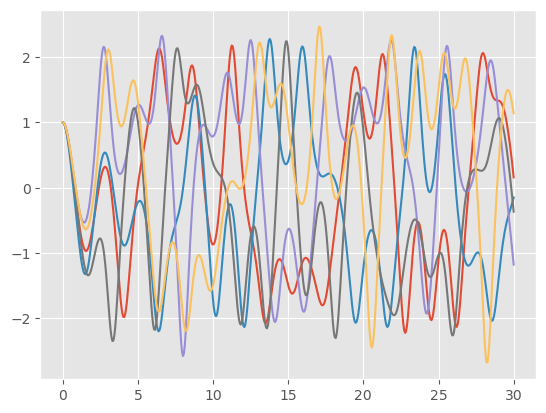

In [22]:
t_grid = jnp.linspace(0,T,500)
values = jax.vmap(lambda t:sol.evaluate(t)[:,0])(t_grid)
for col in values.T:
    plt.plot(t_grid,col)

In [23]:
dt = 0.1
t_train = jnp.arange(0,T,dt)
x_vals = jax.vmap(lambda t:sol.evaluate(t)[:,0])(t_train)
noise_sigma = 0.05
x_train = x_vals + noise_sigma*jax.random.normal(key(31),x_vals.shape)

In [24]:
from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant,CholRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel,PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR,PolynomialLibrary

polylib = PolyLib(degree = 3,include_interaction=False)

trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.,feature_map=polylib)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
n_colloc = 500
colloc_weight = 50. * n_colloc * 10
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.1,alpha = 0.01)
    )

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )


optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x0','x1','x2','x3','x4'],
    input_orders = (0,1),
    ode_order = 2
)

In [25]:
# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    t_train,
    x_train,
)
model.print()


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.00234844, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 250000.0}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 7.364e+05, gradnorm = 1.282e+07, alpha = 4.167, improvement_ratio = 0.9281
Iteration 1, loss = 3.693e+03, gradnorm = 2.073e+07, alpha = 3.472, improvement_ratio = 0.995
Iteration 2, loss = 578.4, gradnorm = 1.24e+06, alpha = 2.894, improvement_ratio = 0.8452
Iteration 3, loss = 178.5, gradnorm = 5.916e+05, alpha = 2.894, improvement_ratio = 0.6993
Iteration 4, loss = 52.66, gradnorm = 3.127e+05, alpha = 2.894, improvement_ratio = 0.7281
Iteration 5, loss = 22.3, gradnorm = 1.647e+05, alpha = 2.894, improvement_ratio = 0.6378
Iteration 100, loss = 1.926, gradnorm = 410.3, alpha = 0.2254, improvement_ratio = 0.6993
Line Search Failed!
Final Iteration Results
Iteration 147, loss = 1.912, gradnorm = 0.0005267, alpha = 60.97, improvement_ratio = -9.578e+04
Model after smooth warm start
(x0)'' = 0.070 1 + 1.406 x0 + -2.155 x1 + -0.088 x2 + 0.154 x3 + -2.027 x4 + -0.008 (x0') + 0.015 (x1') + 0.044 (x2') + -0.067 (x4') + -0.005 x0^2 + -0.014 x1^2 + 0.005 x2^2 + 0.013 x3^2 +

In [26]:
def model_ode(t,x,args=None):
	return jnp.vstack([x[:,1],model.predict(x.T.flatten())]).T
dt0 = 0.0025
T = 30.
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)
model_sol = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(model_ode),
	solver = diffrax.Tsit5(),
	t0=0.,
	t1=T,
	dt0=dt0,
	y0=initial_conditions,
	saveat=save_at,
    stepsize_controller=stepsize_controller,
    max_steps = int(20 * (T/dt0)),
)


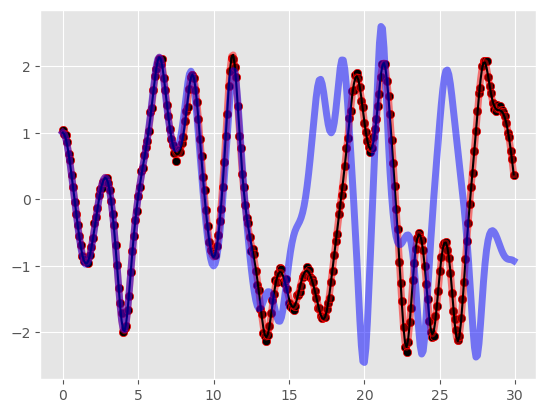

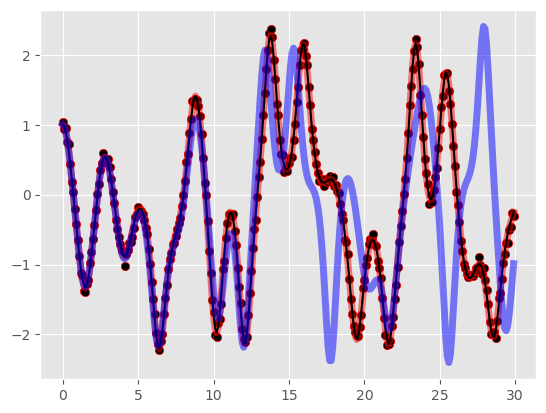

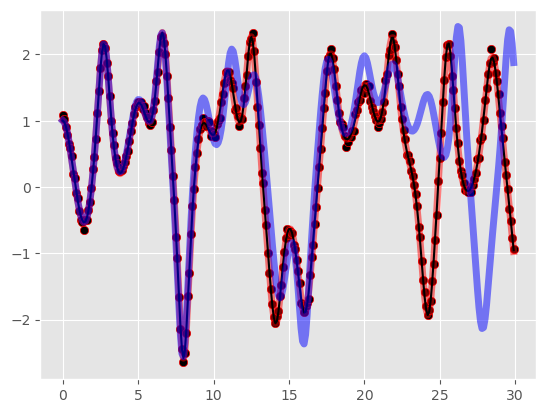

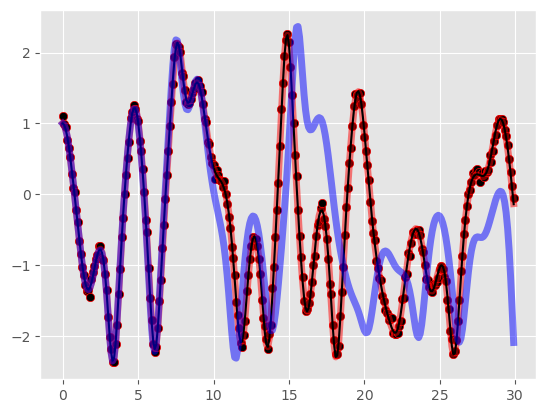

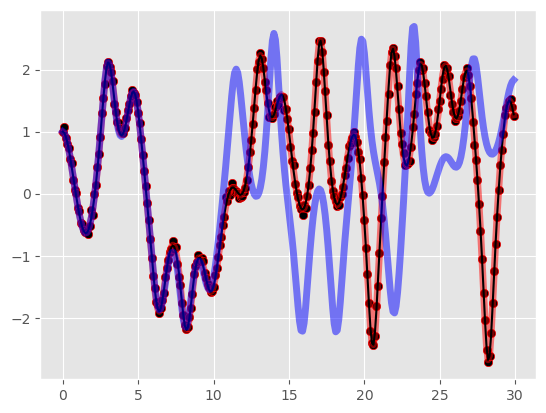

In [33]:
state_preds = model.predict_state(t_train)
integrated_model = jax.vmap(lambda t:model_sol.evaluate(t)[:,0])(t_train)
for i in range(n):
    plt.scatter(t_train,x_train[:,i],edgecolors = 'red',c = 'black')
    plt.plot(t_train,state_preds[:,i],c='red',lw = 5,alpha = 0.5)
    plt.plot(t_train,x_vals[:,i],c='black')
    plt.plot(t_train,integrated_model[:,i],c='blue',alpha = 0.5,lw = 5)
    plt.show()